In [458]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,CategoricalNB
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import KBinsDiscretizer

In [459]:
# column_names = ['survival','still-alive','age-ate-heart-attack','pericardial-effusion','fractional-shortening','epps','lvdd','wall-motion-score','wall-motion-index','mult','name','group','alive-at-1']
# df = pd.read_csv('echocardiogram/echocardiogram.data',names=column_names,na_values='?')

In [460]:
font_size = 18

In [461]:
df=pd.read_csv("heart_disease.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   270 non-null    int64  
 1   sex                                   270 non-null    int64  
 2   chest                                 270 non-null    int64  
 3   resting_blood_pressure                270 non-null    int64  
 4   serum_cholestoral                     270 non-null    int64  
 5   fasting_blood_sugar                   270 non-null    int64  
 6   resting_electrocardiographic_results  270 non-null    int64  
 7   maximum_heart_rate_achieved           270 non-null    int64  
 8   exercise_induced_angina               270 non-null    int64  
 9   oldpeak                               270 non-null    float64
 10  slope                                 270 non-null    int64  
 11  number_of_major_ves

In [462]:
categorical_columns = ['sex','chest','fasting_blood_sugar','resting_electrocardiographic_results','exercise_induced_angina','slope','number_of_major_vessels','thal']
continous_columns = ['age','resting_blood_pressure','serum_cholestoral','maximum_heart_rate_achieved','oldpeak']

In [463]:
# df = df[df['serum_cholestoral']<500]
# df = df[df['age']<77]

In [464]:
target = df['result']
features = df.drop(columns=['result'])

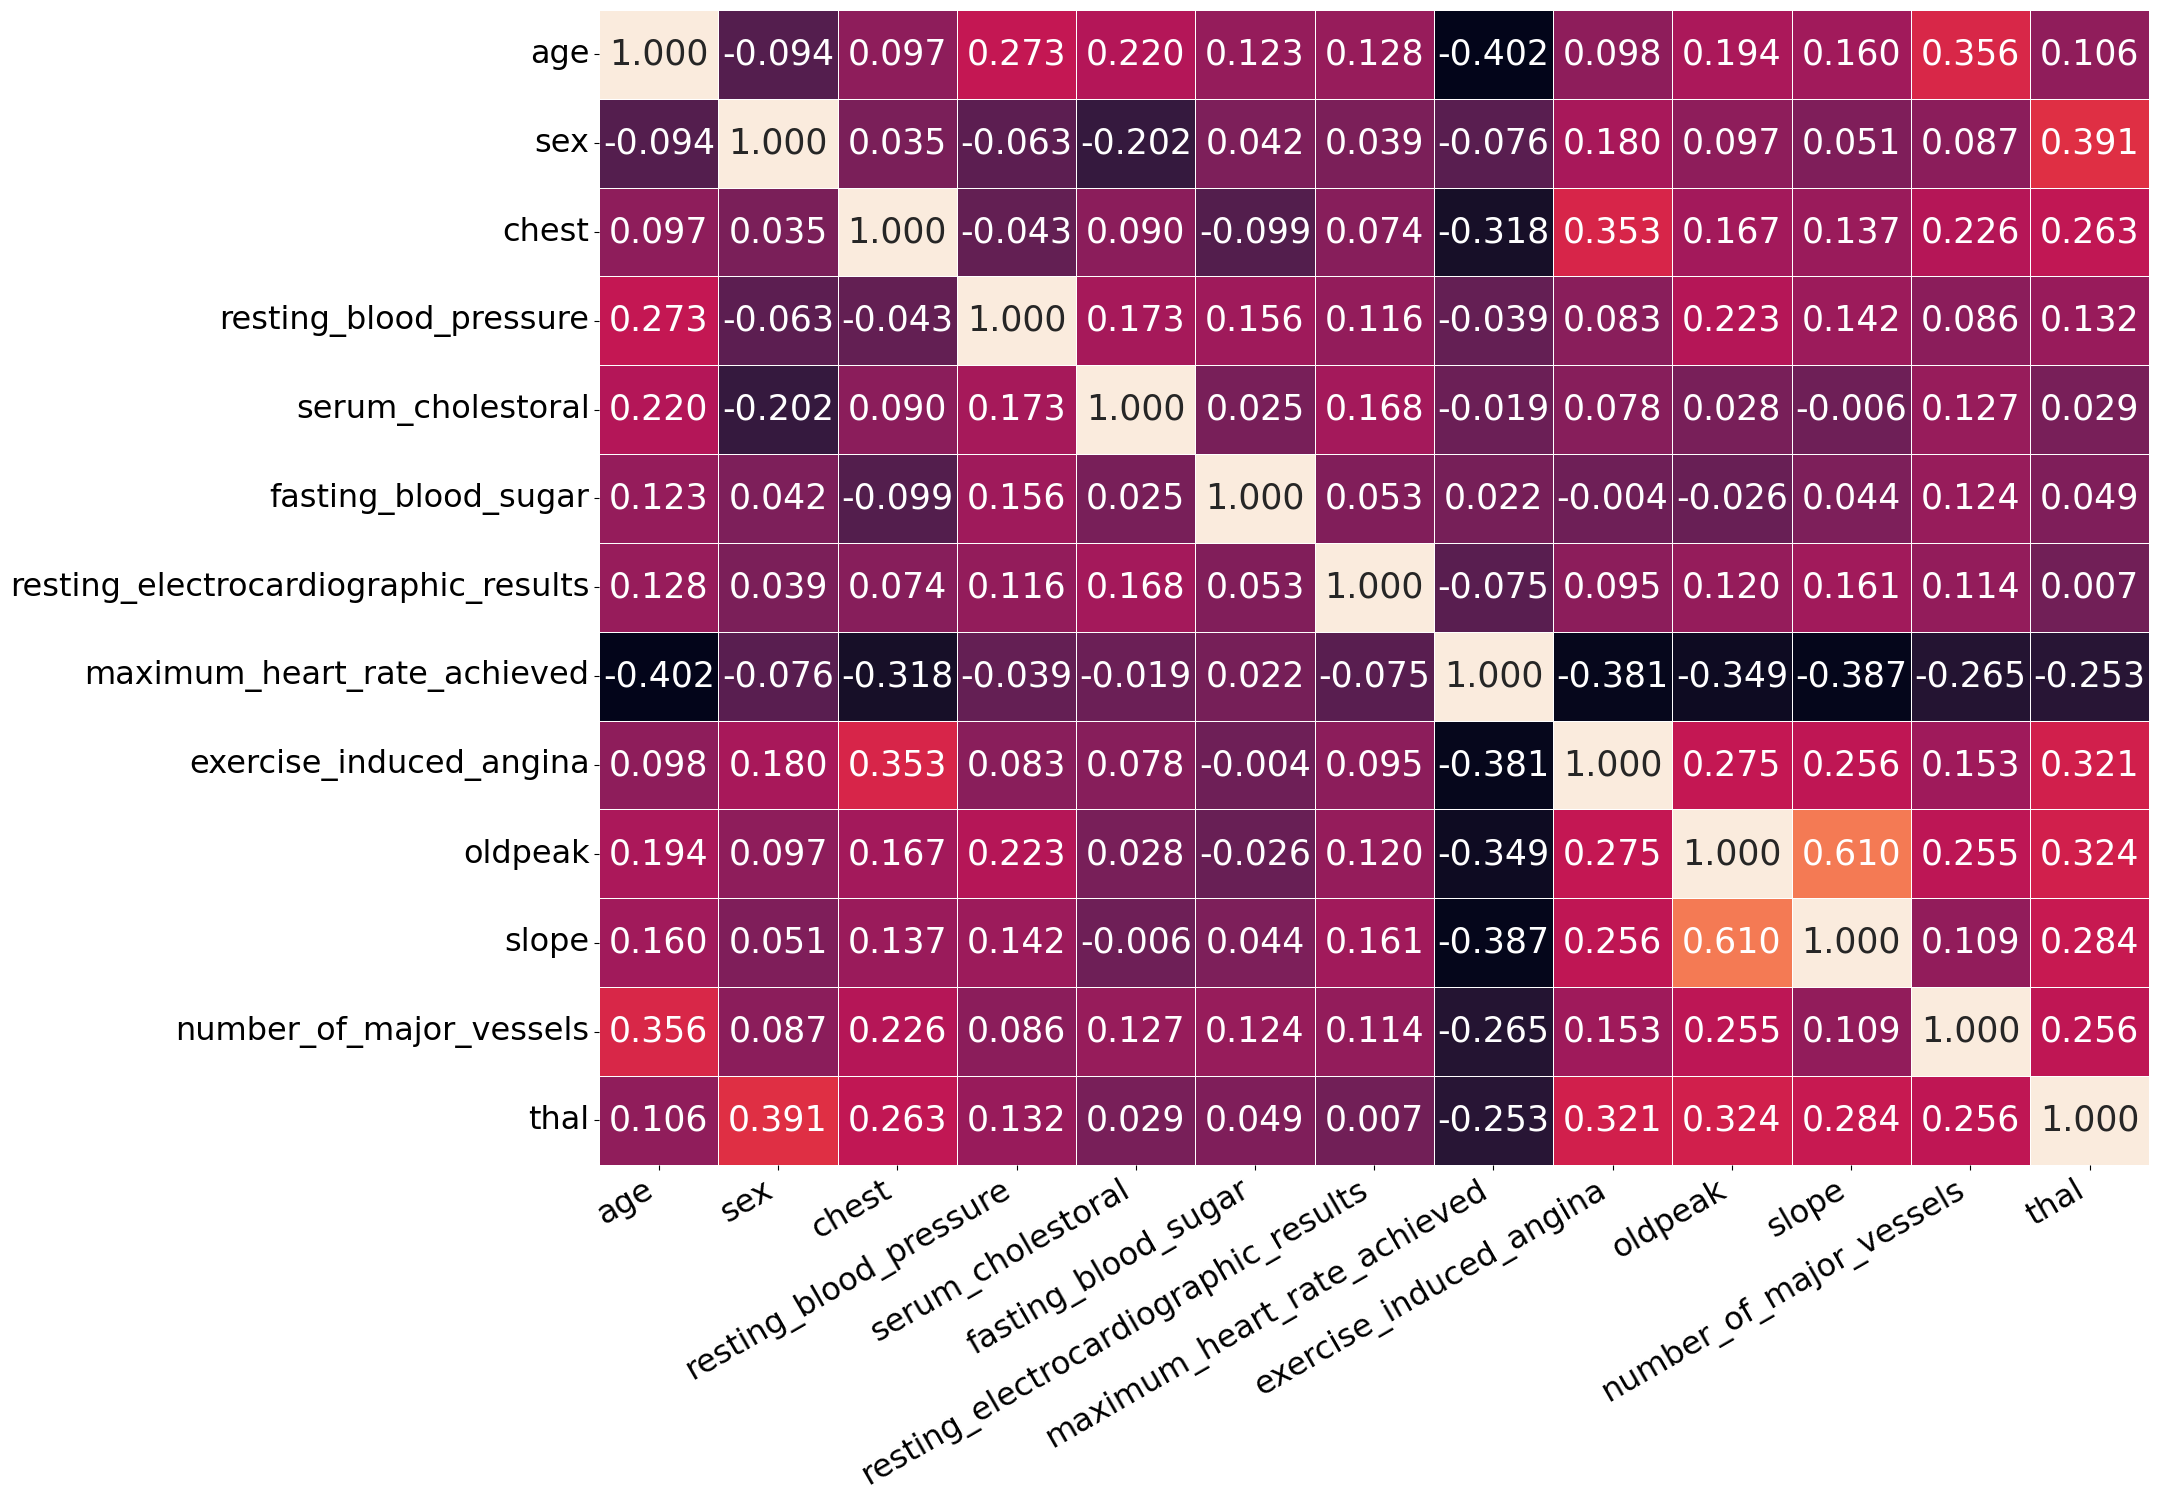

In [465]:
corr_matrix = features.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', linewidths=0.5, annot_kws={"size": 25}, cbar=False)  
plt.xticks(rotation=30, ha='right', fontsize=font_size+5)  
plt.yticks(rotation=0, fontsize=font_size+5) 
plt.savefig('Correlation Matrix', bbox_inches='tight')
plt.show()


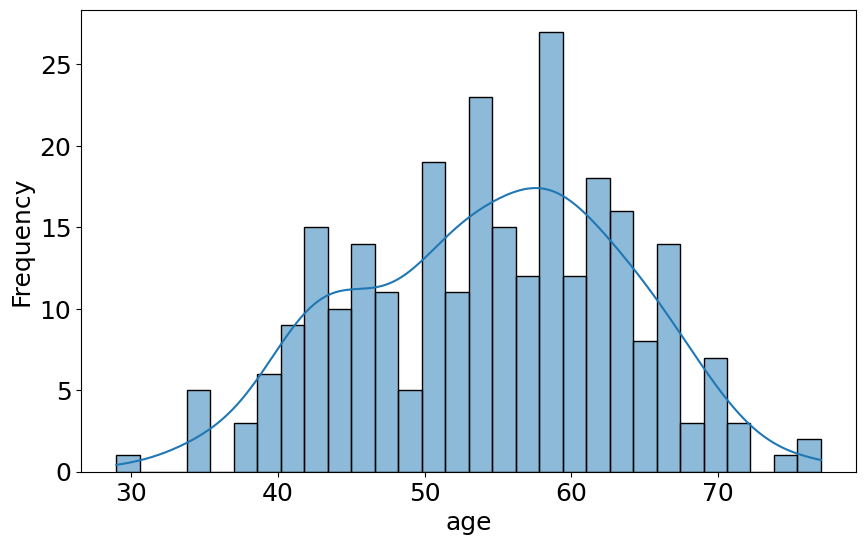

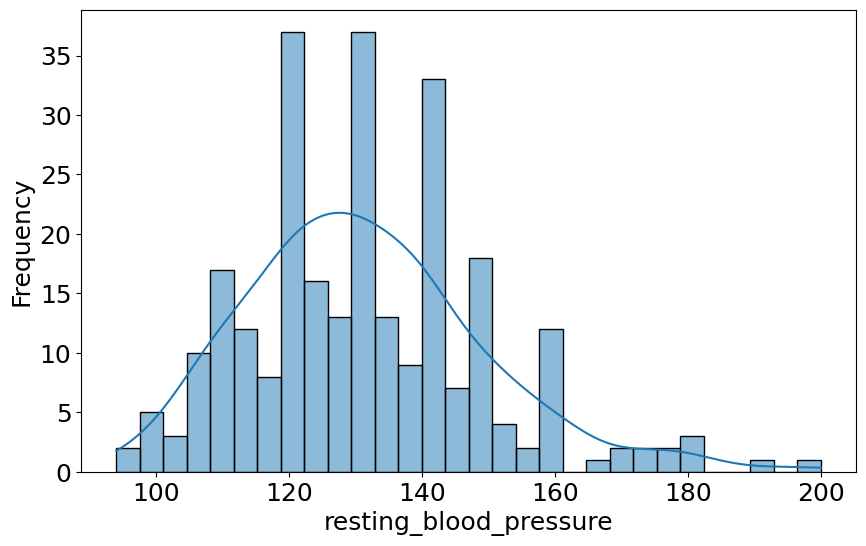

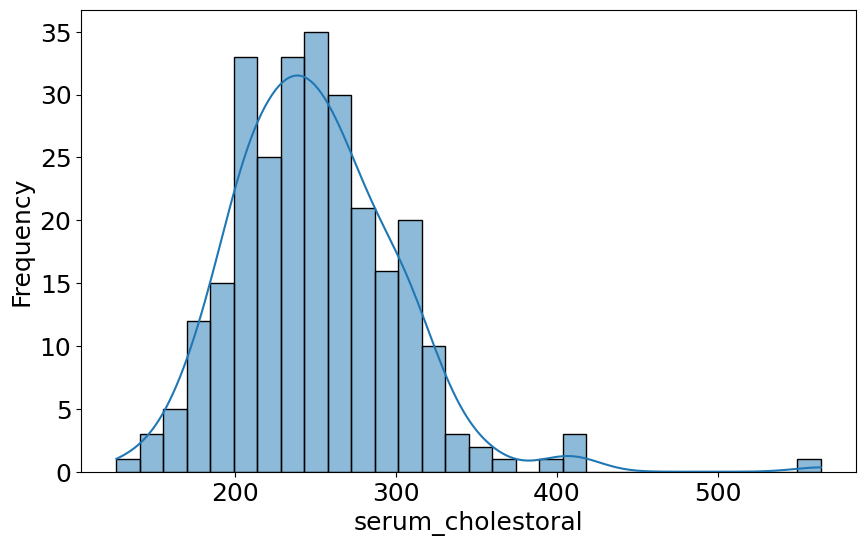

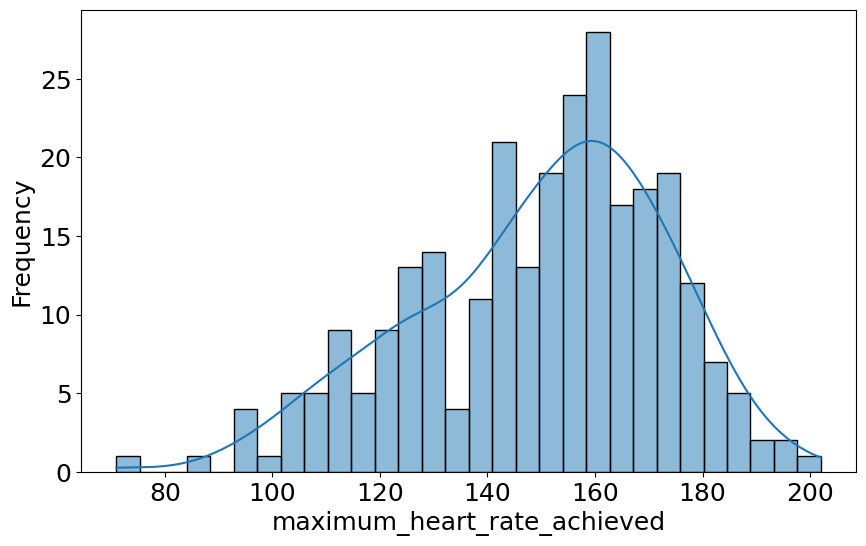

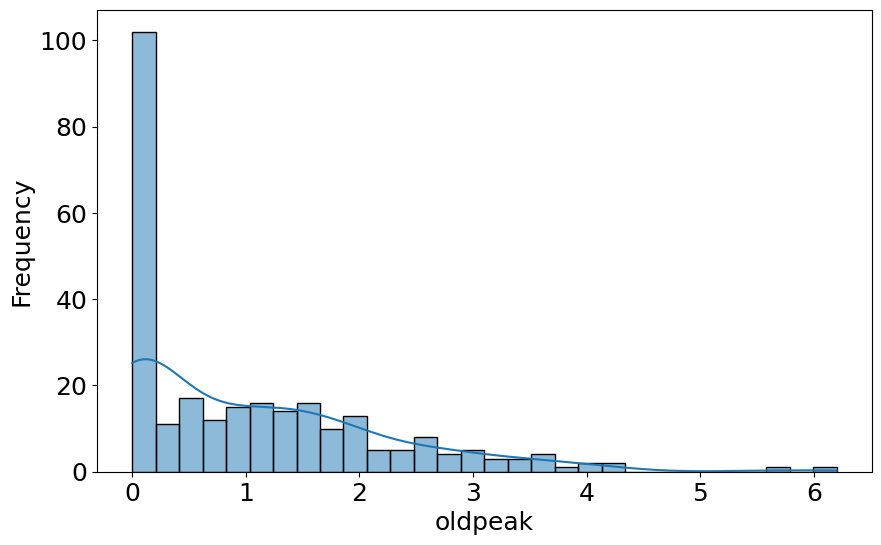

In [466]:
for columns in continous_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[columns].dropna(), kde=True, bins=30)
    plt.xlabel(columns,fontsize = font_size)
    plt.ylabel('Frequency',fontsize=font_size)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.savefig(f'Distribution of {columns}', bbox_inches='tight')
    plt.show()


In [467]:
df['result'].value_counts()

result
0    150
1    120
Name: count, dtype: int64

In [468]:

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=56,stratify=target)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (216, 13) (216,)
Test set shape: (54, 13) (54,)


C:\Users\nimes\AppData\Local\Temp\ipykernel_1404\3419180749.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe.replace({True:0, False:1},inplace=True)


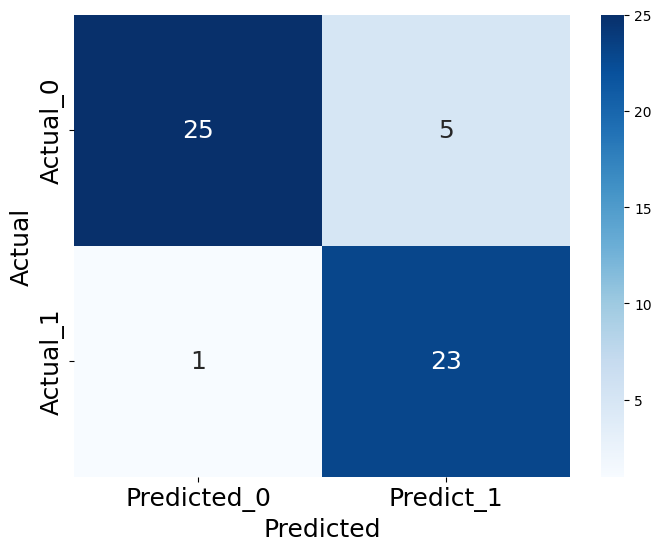

              precision    recall  f1-score   support

           0       0.96      0.83      0.89        30
           1       0.82      0.96      0.88        24

    accuracy                           0.89        54
   macro avg       0.89      0.90      0.89        54
weighted avg       0.90      0.89      0.89        54



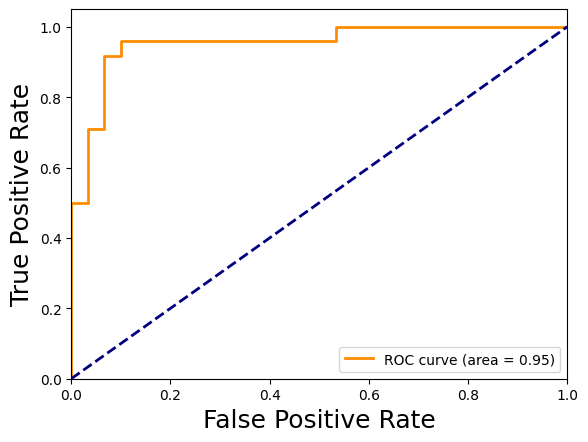

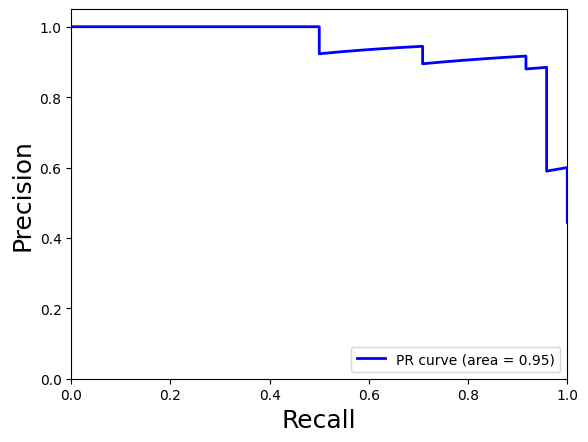

In [469]:
X_train_conti = X_train[continous_columns]
X_test_conti = X_test[continous_columns]

X_train_cat = X_train[categorical_columns]
X_test_cat = X_test[categorical_columns]

hybrid_conti = GaussianNB()
hybrid_conti.fit(X_train_conti,y_train)
y_pred_conti = hybrid_conti.predict_proba(X_test_conti)

hybrid_cat = CategoricalNB()
hybrid_cat.fit(X_train_cat,y_train)
y_pred_cat = hybrid_cat.predict_proba(X_test_cat)

hybrid_proba = (y_pred_conti + y_pred_cat)/2

dataframe = pd.DataFrame(hybrid_proba[:,0])
dataframe = (dataframe>0.5)
dataframe.replace({True:0, False:1},inplace=True)

cm=confusion_matrix(y_test, dataframe)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted_0', 'Predict_1'],
            yticklabels=['Actual_0', 'Actual_1'],
            annot_kws={"size":font_size})
plt.xlabel('Predicted',fontsize=font_size)
plt.ylabel('Actual',fontsize=font_size)
plt.xticks(fontsize=font_size) 
plt.yticks(fontsize=font_size)
plt.savefig('Confusion Matrix Hybrid', bbox_inches='tight')
plt.show()
print(classification_report(y_test, dataframe))


fpr, tpr, _ = roc_curve(y_test, hybrid_proba[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=font_size)
plt.ylabel('True Positive Rate',fontsize=font_size)
plt.legend(loc="lower right")
plt.savefig('ROC Curve Hybrid', bbox_inches='tight')
plt.show()

# Precision-Recall Curve and AUC
precision, recall, _ = precision_recall_curve(y_test, hybrid_proba[:, 1])
pr_auc = average_precision_score(y_test, hybrid_proba[:, 1])
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall',fontsize=font_size)
plt.ylabel('Precision',fontsize=font_size)
plt.legend(loc="lower right")
plt.savefig('PR Curve Hybrid', bbox_inches='tight')
plt.show()

[0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1
 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1]
[0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0
 0 1 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1]
[True, True, True, True, True, True, False, True, True, False, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, False, True, True, False, True, False, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True]


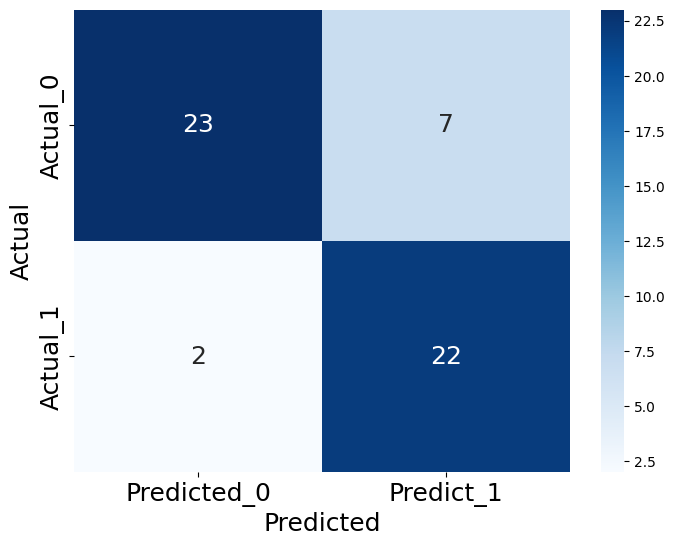

              precision    recall  f1-score   support

           0       0.92      0.77      0.84        30
           1       0.76      0.92      0.83        24

    accuracy                           0.83        54
   macro avg       0.84      0.84      0.83        54
weighted avg       0.85      0.83      0.83        54



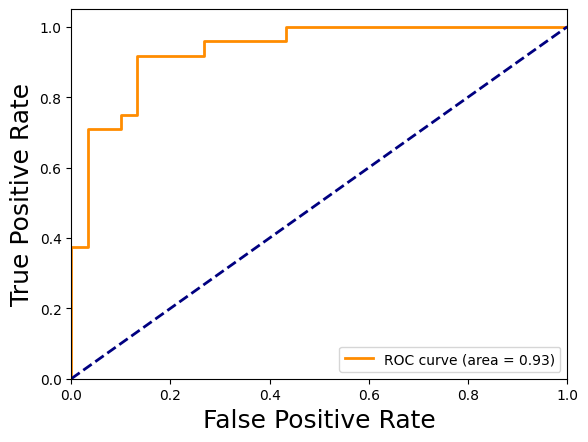

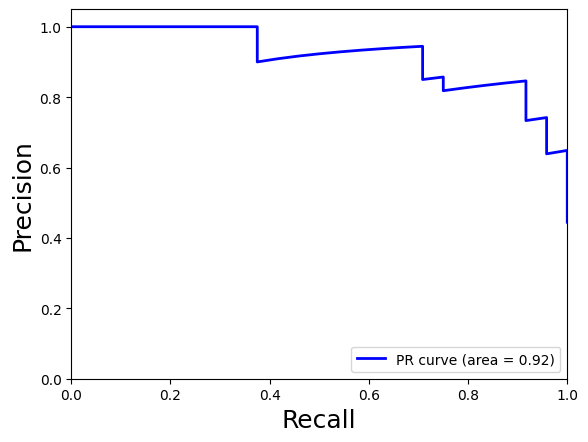

In [470]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = np.asarray(gnb.predict(X_test))
y_pred_proba = gnb.predict_proba(X_test)[:, 1]
print(y_pred)
print(np.asarray(y_test))
y_pred_true_false = [y_pred[i] == np.asarray(y_test)[i] for i in range(len(y_pred))]
print(y_pred_true_false)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted_0', 'Predict_1'],
            yticklabels=['Actual_0', 'Actual_1'],
            annot_kws={"size":font_size})
plt.xlabel('Predicted',fontsize=font_size)
plt.ylabel('Actual',fontsize=font_size)
plt.xticks(fontsize=font_size) 
plt.yticks(fontsize=font_size)
plt.savefig('Confusion Matrix Gaussian', bbox_inches='tight')
plt.show()

report = classification_report(y_test, y_pred)
print(report)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize = font_size)
plt.ylabel('True Positive Rate',fontsize = font_size)
plt.legend(loc="lower right")
plt.savefig('ROC Curve Gaussian', bbox_inches='tight')
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall',fontsize = font_size)
plt.ylabel('Precision',fontsize = font_size)
plt.legend(loc="lower right")
plt.savefig('PR Curve Gaussian', bbox_inches='tight')
plt.show()

[0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0
 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1]
[0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0
 0 1 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1]
[True, True, True, True, True, True, True, False, True, False, True, False, True, True, False, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True]


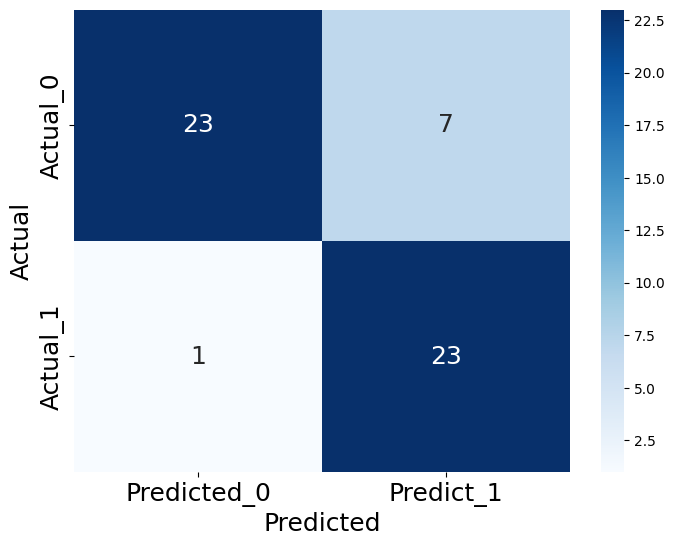

              precision    recall  f1-score   support

           0       0.96      0.77      0.85        30
           1       0.77      0.96      0.85        24

    accuracy                           0.85        54
   macro avg       0.86      0.86      0.85        54
weighted avg       0.87      0.85      0.85        54



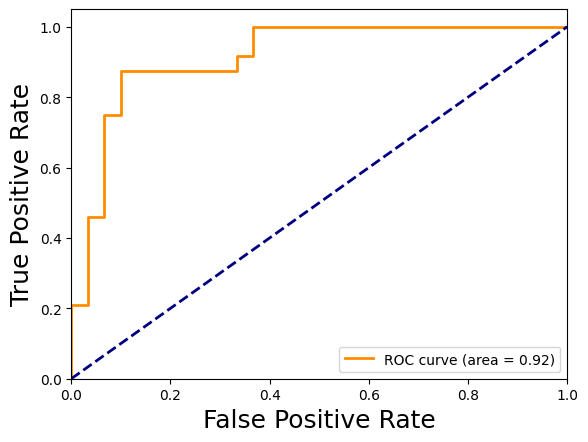

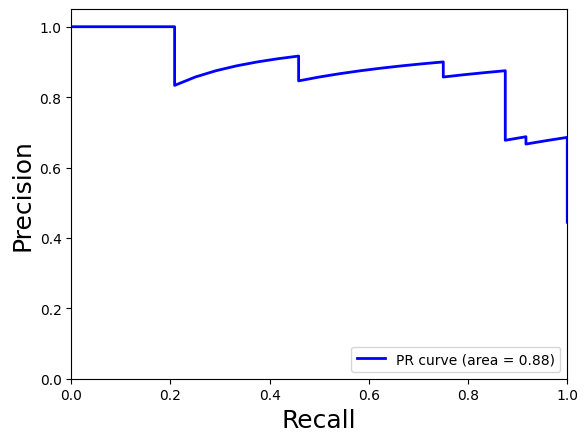

In [471]:
kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
for column in continous_columns:
    kbins.fit(X_train[[column]])
    X_train[column] = kbins.transform(X_train[[column]])
    X_test[column] = kbins.transform(X_test[[column]])

cnb = CategoricalNB()
cnb.fit(X_train, y_train)
y_pred = cnb.predict(X_test)
y_pred_proba = gnb.predict_proba(X_test)[:, 1]
print(y_pred)
print(np.asarray(y_test))
y_pred_true_false = [y_pred[i] == np.asarray(y_test)[i] for i in range(len(y_pred))]
print(y_pred_true_false)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted_0', 'Predict_1'],
            yticklabels=['Actual_0', 'Actual_1'],
            annot_kws={"size":font_size})
plt.xlabel('Predicted',fontsize=font_size)
plt.ylabel('Actual',fontsize=font_size)
plt.xticks(fontsize=font_size) 
plt.yticks(fontsize=font_size)
plt.savefig('Confusion Matrix Categorical', bbox_inches='tight')
plt.show()

report = classification_report(y_test, y_pred)
print(report)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize = font_size)
plt.ylabel('True Positive Rate',fontsize = font_size)
plt.legend(loc="lower right")
plt.savefig('ROC Curve Categorical', bbox_inches='tight')
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall',fontsize = font_size)
plt.ylabel('Precision',fontsize = font_size)
plt.legend(loc="lower right")
plt.savefig('PR Curve Categorical', bbox_inches='tight')
plt.show()